In [3]:
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.helper import draw_spring, load_graph_from_json
np.random.seed(123)

# 2 Network Properties

This chapter will provide more detail about the structure of networks. The chapter is a bit 'dry', as it has less practical applicability than the other chapters. Nevertheless, learning about network properties can provide for a solid basis for the understanding of network analysis.
>Readers for who a technical disposition of network properties is not a priority may skip this chapter.

## 2.1 Paths, Shortest Paths, and Distance between Nodes

A path is a series of steps getting from node A to node B. For any node of the network, it is possible to calculate the path it has to other nodes (if such a path exists) and its distance. The distance is the number of steps, or the number of steps weighted by any relevant weight metric. 

Some complications deserve mention here, which are further discussed below:

* Disconnected nodes
* Fully connected networks
* Shortest path
* Weighted paths
* Random paths
* Eccentricity and network diameter

### A) Disconnected Nodes

It is not guaranteed that there will be a path between two nodes. It is possible that two sets of nodes are simply not connected. In this case there is no path between the nodes, directly or indirectly. This situation can be observed in the example below, where nodes A, B, and C, are disconnected from nodes D and E.

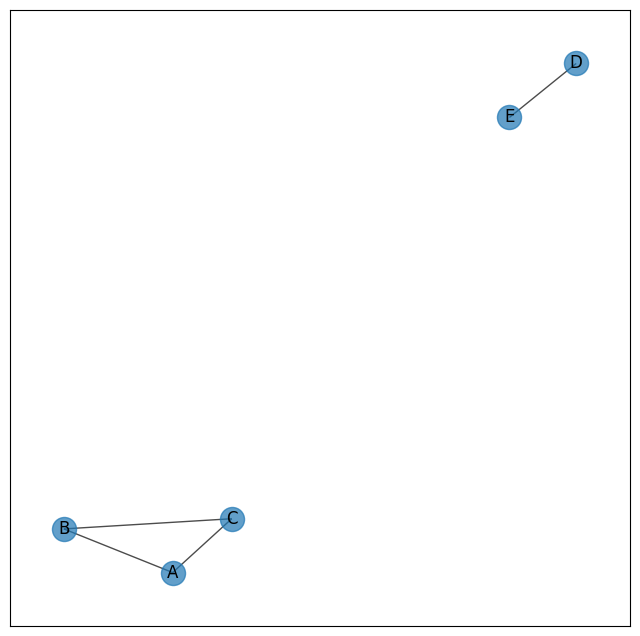

In [4]:
g_disconnected = nx.Graph()
g_disconnected.add_nodes_from(['A','B','C','D','E'])
g_disconnected.add_edges_from([('A','B'),('B','C'), ('C','A'),('D','E')])
draw_spring(g_disconnected)

### B) Fully connected networks

A network is fully connected if every node is connected to every other node. To see how this will look consider these graphs from Wolfram (https://mathworld.wolfram.com/CompleteGraph.html)

![image](images/ch2/wolfram.png)

A fully connected network will have a fixed number of edges as a function of how many nodes it has. That is, for every node $n$ a fully connected network will have $ \frac{n(n-1)}{2} $ edges. Note that for such networks it would be pointless to try to distinguish between nodes using measures like centrality or community, unless the edges have differing weights.

It is not always possible to tell visually if a network is fully connected , as one can see from the network below (which with 25 nodes, remains small). In such cases one can test full-connectedness using networkx ```nx.is_connected()```


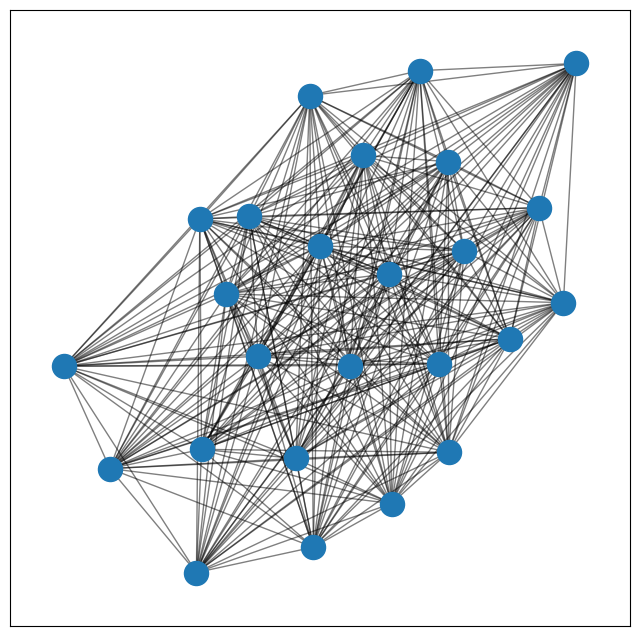

In [5]:
g_distances = load_graph_from_json("data/g_distances.json")
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_distances, seed=121)

nx.draw_networkx_nodes(g_distances, pos)
nx.draw_networkx_edges(g_distances, pos=pos, edge_color='black', alpha=0.5)

In [6]:
nx.is_connected(g_distances)

True

### C) Shortest paths

The shortest path is the path that will reach a node in the smallest number of steps. There can be more than one "shortest path" (but all the shortest paths will have the same smallest number of steps). For example, if we look at the kite graph, there are two shortest paths from 7 to 3, one going through 6, and another going through 5. There are longer paths too, for example, 7 -> 5 -> 2 -> 3. These may not be immediately relevant, but might be interesting possible random paths, between 7 and 3.

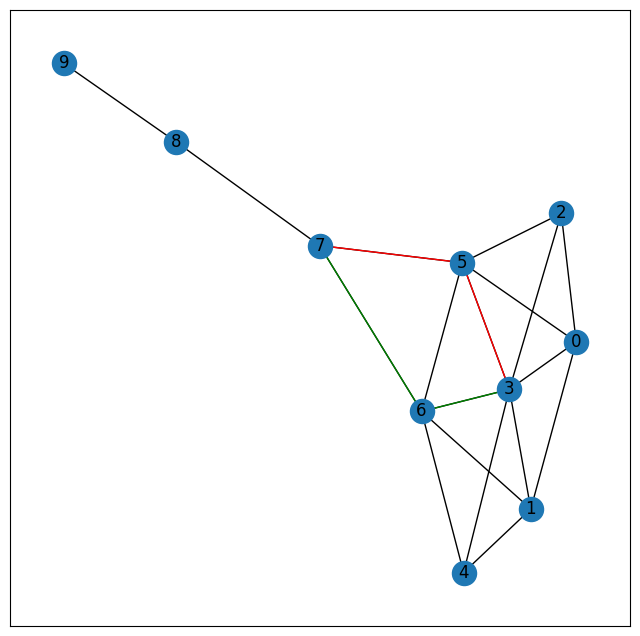

In [7]:
g_kite = nx.krackhardt_kite_graph()
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,5),(5,3)], edge_color="red", pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,6),(6,3)], edge_color="green", pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

While shortest paths can be easy to 'see' in small graphs like this one, this will not be possible in more complex graphs. Finding the shortest path will then be a non-trivial problem. This process is automated by network analysis libraries and programs. 

Shortest paths are useful for many purposes. In the context of this presentation, it will be seen that they are key ingredients in many algorithms for identifying the most important or most central nodes of a network.

For the unweighted graphs that we are using, a shortest path counts discrete 'steps' between nodes. This implies that all the nodes are a unit distance away. However, it is also possible to have weighted paths, as we will discuss later. 

### D) Random paths

The length of the shortest path will be a definite number. However, there may be a large or arbitrary number of non-shortest paths wandering through the nodes. 

A single arbitrary path will not be of much interest (why this one?, why not another one?), but if we allow movement randomly from node to node, these random paths - random walks - can become useful (unless the random walk get 'stuck' in a loop). We may be interested not only in the shortest path between A and B, but in the average path distance between A and B, taking into account routes that go more or less directly from A to B as well as those that make longer detours. By measuring a number of random walks for a number of nodes in the network, it will often become clear that some nodes are more likely to be passed through than other nodes, which suggests these nodes are more central and perhaps therefore more relevant or interesting.

We illustrate the shortest path with a coding example. NetworkX does not have a function to generate a single random path starting from a given node. However, we can create one with the neighbors attribute of the Graph object. The steps are more or less like this:

1. Select a number of steps for the walk. In this case four steps. Execute the tasks below until you hit four steps.
2. Select a particular node to start with, for example node 7.
3. Find all the neighbors of node 7 (in this case, 5, 6, 8).
4. Randomly choose one of these nodes to go to. Say choose node 5.
5. Update the value of your start position to the chosen node, in this case 5.
6. Record that you have made one step (3 to go).
7. If you have made less than four steps, go back to step 2. If you have made four steps, stop.

These steps can be implemented in code as follows:

In [8]:
# here we are limiting the number of steps to 4, we get 5 steps in the answer because the answer includes the start node, and n is initialized at 0.

n = 0
start = 7
history = [start]
while n < 4:
  my_neighbors = list(g_kite.neighbors(start))
  move_to_node = np.random.choice(my_neighbors)
  history.append(move_to_node.tolist())
  start = move_to_node
  n += 1

print(history)

[7, 8, 9, 8, 7]


Most likely we will not be interest in a single random path, but in lots of them, and they can be generated in bulk using the ```generate_random_paths``` function.

In [10]:
random_paths = nx.generate_random_paths(g_kite, sample_size=10, path_length=4)
for i in random_paths:
    print(i)

[7, 6, 5, 0, 5]
[1, 3, 2, 0, 2]
[6, 5, 7, 6, 5]
[3, 6, 3, 4, 1]
[6, 7, 5, 3, 1]
[3, 6, 7, 6, 3]
[6, 3, 5, 0, 3]
[3, 4, 3, 6, 7]
[1, 0, 2, 3, 5]
[8, 7, 6, 1, 0]


### E) Weighted edges


An edge can show that there is a relationship between nodes A and B. The nature of that relationship can be many things, such as there being a train between A and B, or that case A cites case B. In these instances the relationship is binary: There either is a connection or there is not.

However, there is a range of cases where one wants to record the strength of a connection and not just its presence. For example, one might want to record not only that there is train path from A to B but also how long that path is in terms of kilometers. We might want to score not only that case A cites case B but also how many times case B is cited by case A. We can add this attribute to the edge by giving weights to edges. For instance, if case A cites case B four times, the edge weight becomes four.

Weighted networks can be represented visually in an intuitive way by using different colors or line styles for their edges. Below is a network using a document similarity matrix. This matrix records how close two documents are in light of the tokens they share (Jaccard distance) and scores them with 1 if they are identical, and 0 if they are completely different. It is made of a set of ECHR Grand Chamber judgments on the extraterritorial application of fundamental rights. 


In the process of comparing the distance between each document, this dataframe is turned into a matrix, and that can be used to build a network. Please see Appendix 1: "Text Similarity Networks" for more details of how this can be done. 

The purpose of this example is to show that if you graph the network without consideration of weight, it gives you a fully connected network, which is a nice geometrical figure, but not very informative. Every document was compared to every other document, so every node is on step (one degree) of separation from every other and so every node has the exact same number of neighbors.

A more informative network structure can be shown if we take consideration of weight. One way to do this is to pick only the edges whose weight meets a certain test. Here we are simply whose weight surpases the mean weight plus one standard deviation.

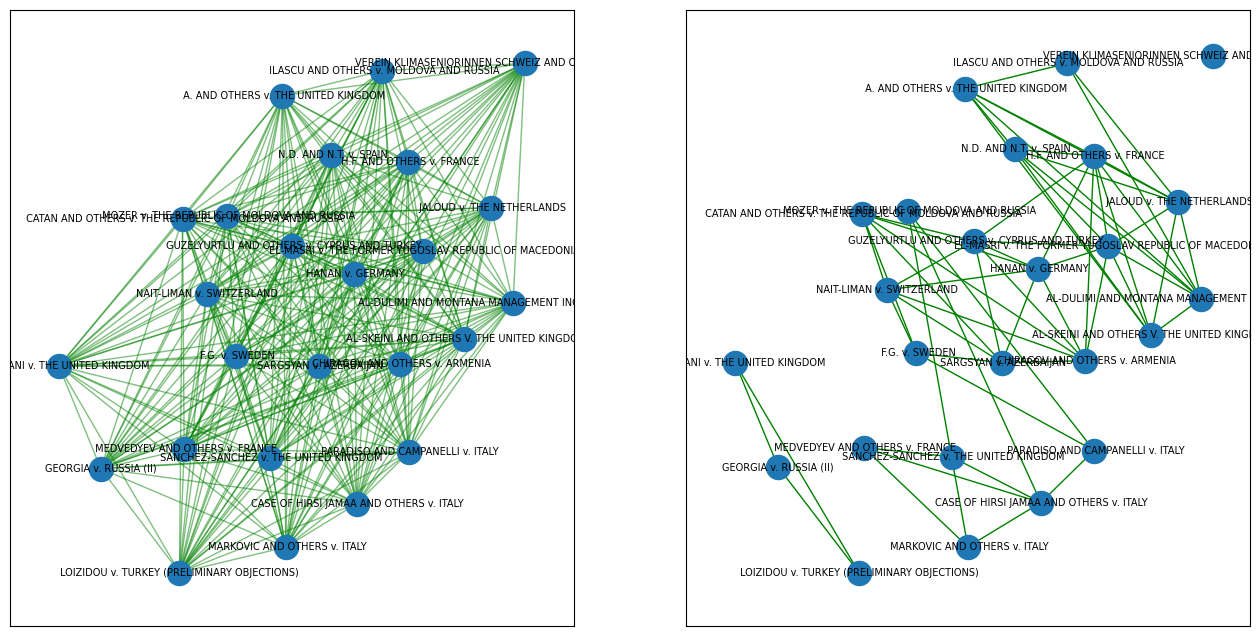

In [11]:
g_distances = load_graph_from_json("data/g_distances.json")
mean_simil = np.mean([z for x,y,z in g_distances.edges.data("weight")])
std_mimil = np.std([z for x,y,z in g_distances.edges.data("weight")])

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
pos = nx.spring_layout(g_distances, seed=121)


nx.draw_networkx_nodes(g_distances, pos, ax=ax[0])
nx.draw_networkx_edges(g_distances, pos=pos, edge_color='green', ax=ax[0], alpha=0.5)
nx.draw_networkx_labels(g_distances, pos=pos, font_size=7, ax = ax[0]);

nx.draw_networkx_nodes(g_distances, pos, ax=ax[1])
lowweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] < mean_simil+std_mimil]
highweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] > mean_simil+std_mimil]
nx.draw_networkx_edges(g_distances, edgelist=highweight, pos=pos, edge_color='green', ax=ax[1])
nx.draw_networkx_labels(g_distances, pos=pos, font_size=7, ax = ax[1]);

We stated that assessing centrality or community of fully connected networks can be pointless, for all the nodes are then by definition connected to all the other nodes, and so they will get identical scores. However, in weighted networks it is not pointless to assess the centrality or community of its nodes, because the edges have different weights. This is illustrated in the section on closeness centrality below.

Calculating shortest paths is different for weighted edges than for unweighted edges. In unweighted graphs it would be a matter of counting the steps on different paths and finding the one with the lowest number of steps, whereas in weighted graphs the procedure is to count the steps and multiply every step by its weight.

Also note that the weight can represent closeness or distance. If it represents distance, then one must simply multiply by it. If it represents closeness, we need to convert it into distance by using its reciprocal.

$$ distance = \frac{1}{closeness} $$ 

### F) Network Density

Recall the fully connected networks discussed earlier:

![image](images/ch2/wolfram.png)

Since every node here will be connected to every other node (there are no strangers, everyone is a neighbor of everyone else, everyone has maximum popularity) it can be said that these networks are maximally dense.

A maximally dense network will have $ \frac{n(n-1)}{2} $ edges. Consequently, a network with 3 nodes can have a maximum of 3 edges, a network with 4 nodes 6 edges, a network with 5 nodes 10 edges, and so forth.

The network density will be the ratio of the number of edges actually present $ m $ to the hypothetical maximum, in other words:

$$ \frac{m}{n(n-1)/2} $$

### G) Eccentricity and Network Diameter

Next we need to consider eccentricity. Eccentricity records the longest shortest path between
every node. In the kite graph above, we can see that the eccentricity of node 9 is 4, as the maximum shortest path that exist between that node and some other node is four steps. Node 7, by contrast, has a maximum eccentricity of 2, as the longest shortest path that exist between it any other node is just 2.

Just as we can be interested in what is the center of a network, we can be interested in how large the network is. However, one cannot just 'eye' a network graph to get a sense of its dimensions, because a graph can be plotted in many different ways and still be the same network.

The diameter of a network is very simple to calculate. It is just the maximum eccentricity value. A network is as wide as the longest shortest path that it includes. For the kite network, no node is further away than four steps from any other (that is the longest shortest path) and thus that is its diameter.

In [12]:
nx.diameter(g_kite)

4

## 2.2. Subgraphs

A graph can be broken down into subgraphs, which have the same (trivially) or less nodes than the original graph. This can be done by specifying the nodes you want to select. Here, for example, we  take the 'tail' out of the kite, by not including nodes 7, 8, and 9 in the subgraph.

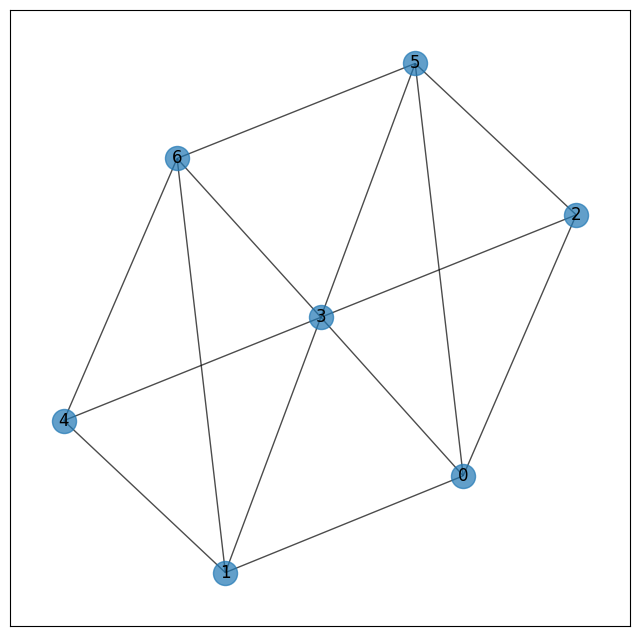

In [13]:
g_subkite = g_kite.subgraph([0,1,2,3,4,5,6])
draw_spring(g_subkite)

The kitegraph is a rather small graph and intuitive to interpret when visualized. The CJEU case law network is a larger one that is uninterpretable when all nodes are visualized.

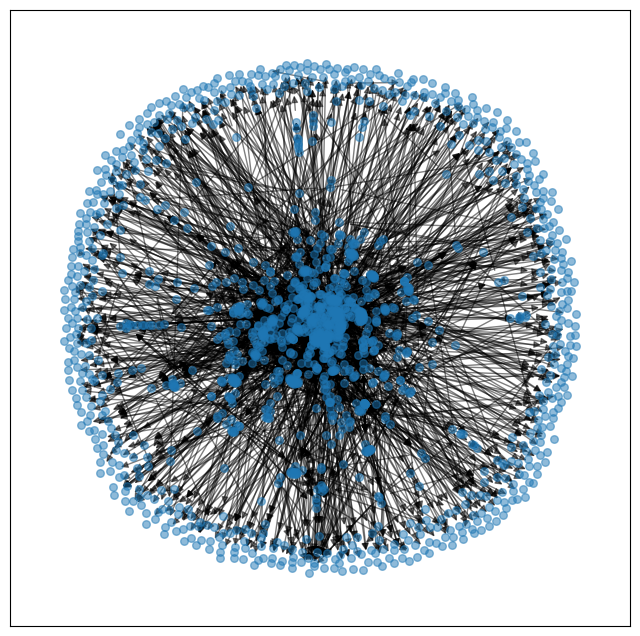

In [14]:
g_consprot = load_graph_from_json("data/g_consprot.json")
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_consprot)
nx.draw_networkx_nodes(g_consprot, pos=pos, node_color="tab:blue", node_size=30, alpha=0.5)
nx.draw_networkx_edges(g_consprot, pos=pos, edge_color="black", alpha=0.5);

One way of making the network more comprehensible, is to create a sub-network. Here, we create and plot a sub-network of cases that have a degree score of at least 25, meaning that they have 25 or more citations (counting both incoming and outgoing citations). The network becomes much smaller now.

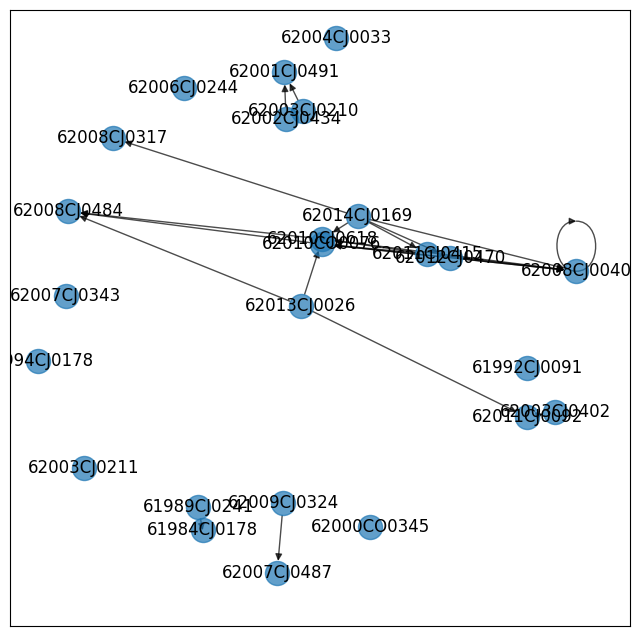

In [15]:
node_degree_dict=nx.degree(g_consprot)
g_consprot2=nx.subgraph(g_consprot,[x for x in g_consprot.nodes() if node_degree_dict[x]>=25])
draw_spring(g_consprot2)

Some nodes are disconnected from the other nodes. This may seem surprising given the fact that the subgraph includes the 'best connected' nodes. This occurs because the subgraph function completely removes the unselected nodes. When such nodes are removed, it is to be expected that the degree values of the nodes in the sub-network also decreases. If some nodes were only connected to unselected nodes they will now appear alone having a degree of 0 in the subgraph.

## 2.3 Ego Networks

One important type of subgraph is the ego network, which is centered on one particular node (the 'ego' or self) and then contains only those nodes that have a path to the ego within a given radius. That is to say, we can see only the nodes that are a defined number of steps away from the ego.

This can be useful to zoom in on one particular set of relations. For example, using the karate club graph we can use ego networks to see all the nodes that are one step away from the karate instructor (node 33 in the networkx version of the dataset).

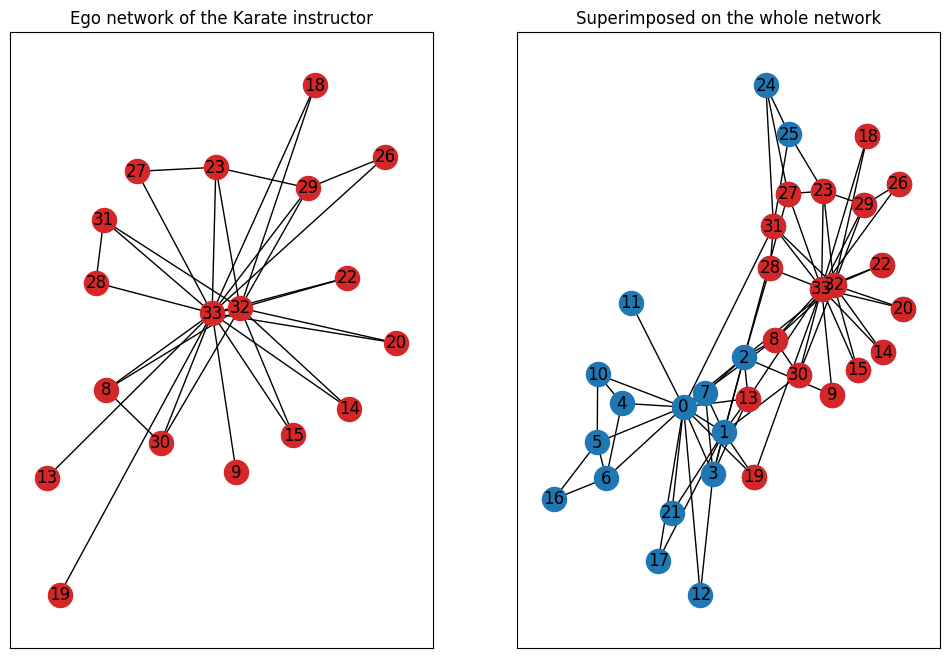

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
g_karate = nx.karate_club_graph()
ego_karate = nx.ego_graph(g_karate, 33)
pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(ego_karate, pos=pos, ax=ax[0], node_color="tab:red")
nx.draw_networkx_labels(ego_karate, pos=pos, ax=ax[0])
nx.draw_networkx_edges(ego_karate, pos=pos, ax=ax[0])
nx.draw_networkx_nodes(g_karate, pos=pos, ax=ax[1])
nx.draw_networkx_nodes(ego_karate, pos=pos, node_color="tab:red", ax=ax[1])
nx.draw_networkx_labels(g_karate, pos=pos, ax=ax[1])
nx.draw_networkx_edges(g_karate, pos=pos, ax=ax[1])
ax[0].set_title("Ego network of the Karate instructor")
ax[1].set_title("Superimposed on the whole network");


## 2.4 Flattening Bipartite Networks

A bipartite network has two types of nodes. One such example already introduced is states (node type 1) and treaties that they have ratified (node type 2).

Because of its bipartite form, such network cannot be directly analyzed using conventional methods such as centrality because then edges to treaties and to countries are treated the same whereas they are qualitatively different in this model. One solution is to project the network into a single level, that is, to flatten it. 

Flattening involves removing the upper level nodes (treaties). Instead one creates connections between the lower level nodes (countries), weighted by how many upper level nodes they shared before. 
>Note that one could also do things the other way around and see how many countries are shared by a treaty.

In [18]:
g_treaties = load_graph_from_json("data/g_treaties.json")
states = [x[0] for x in list(g_treaties.nodes(data="bipartite")) if x[1] == 0]
treaties = [x[0] for x in list(g_treaties.nodes(data="bipartite")) if x[1] == 1]
g_treaties_flat = nx.bipartite.weighted_projected_graph(g_treaties, nodes=states)

Text(0.5, 1.0, 'Flattened Bipartite Network')

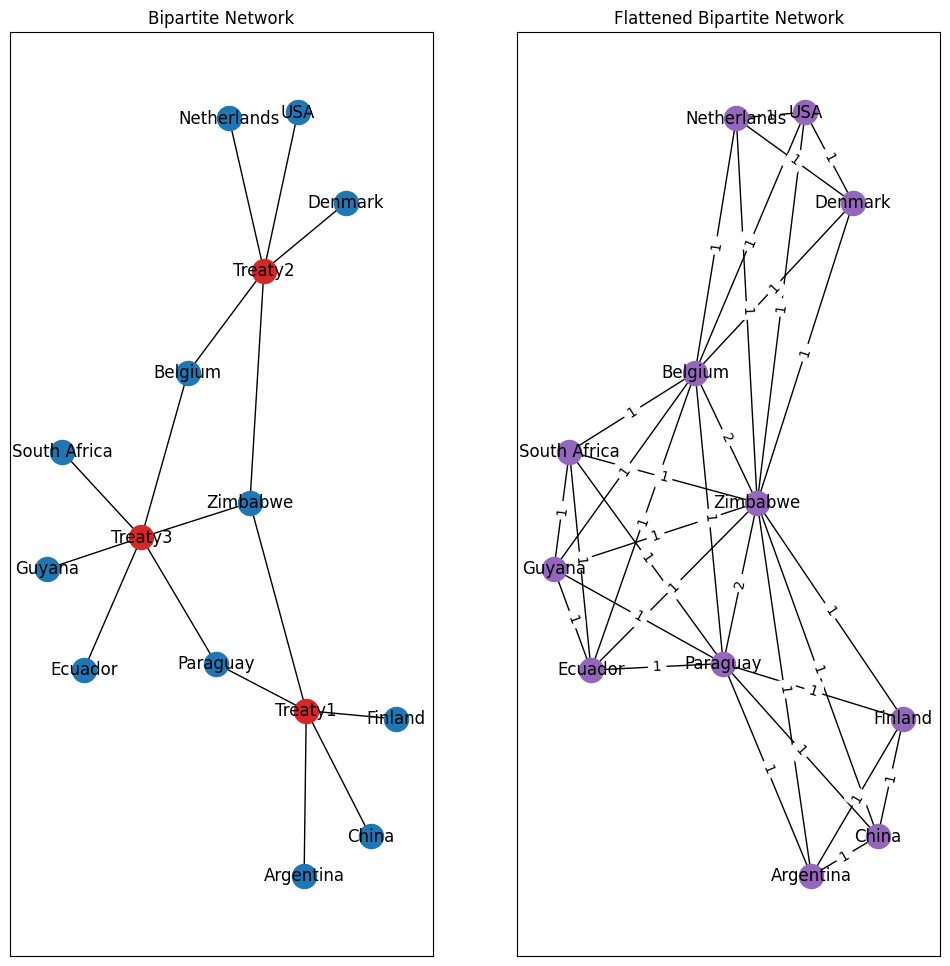

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))

pos = nx.spring_layout(g_treaties, seed=123)
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist= states, node_color='tab:blue', ax=ax[0])
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist= treaties, node_color='tab:red', ax=ax[0])
nx.draw_networkx_edges(g_treaties, pos=pos, ax=ax[0])
nx.draw_networkx_labels(g_treaties, pos=pos, ax=ax[0]);

edgelabels = {(e,w):list(g_treaties_flat.get_edge_data(e,w).values())[0] for e,w in g_treaties_flat.edges}
pos = nx.spring_layout(g_treaties, seed =123)
nx.draw_networkx_nodes(g_treaties_flat, pos=pos, node_color="tab:purple", ax=ax[1])
nx.draw_networkx_edges(g_treaties_flat, pos=pos, ax=ax[1])
nx.draw_networkx_labels(g_treaties_flat, pos=pos, ax=ax[1]);
nx.draw_networkx_edge_labels(g_treaties_flat, pos, edge_labels=edgelabels, ax=ax[1]);
ax[0].set_title("Bipartite Network")
ax[1].set_title("Flattened Bipartite Network")

## 2.5 Network Metadata

Networks can store more than just connections between nodes and edges. The nodes and the edges can have attributes. We have already encountered one of such attributes, which is the 'weight' attribute on an edge. Accessing such information we can query the network and visualize sub-networks that meet specific criteria. 

Let us first query edge weights using the distances network that already has weights.

In [20]:
list(g_distances.edges(data="weight"))[0:5]

[(' MEDVEDYEV AND OTHERS v. FRANCE',
  ' AL-SKEINI AND OTHERS V. THE UNITED KINGDOM',
  0.28813614712778907),
 (' MEDVEDYEV AND OTHERS v. FRANCE',
  'CASE OF HIRSI JAMAA AND OTHERS v. ITALY',
  0.7988611356881962),
 (' MEDVEDYEV AND OTHERS v. FRANCE',
  ' H.F. AND OTHERS v. FRANCE',
  0.3100084370385994),
 (' MEDVEDYEV AND OTHERS v. FRANCE',
  ' SANCHEZ-SANCHEZ v. THE UNITED KINGDOM',
  0.8203609569556498),
 (' MEDVEDYEV AND OTHERS v. FRANCE',
  ' MARKOVIC AND OTHERS v. ITALY',
  0.9185916491668258)]

We can then filter out the nodes or edges that satisfy a certain edge-weight condition. This is something we already did above with our text similarity leaving only edges that have a weight that is higher than one standard deviation above the mean.

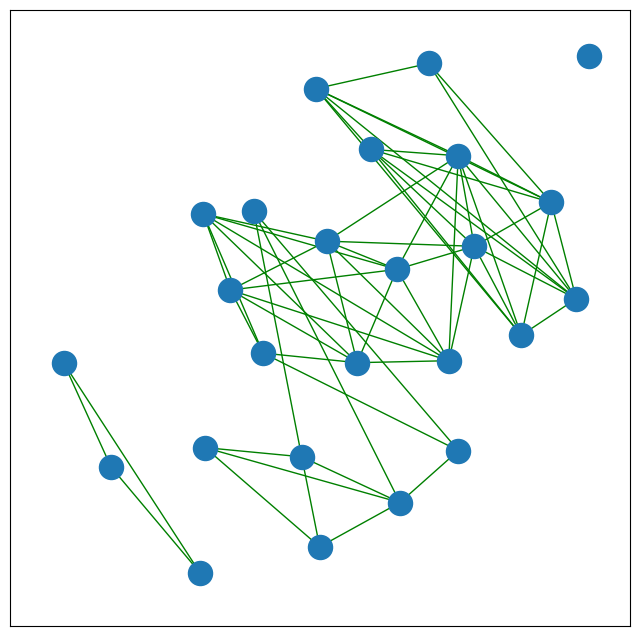

In [21]:
mean_simil = np.mean([z for x,y,z in g_distances.edges.data("weight")])
std_mimil = np.std([z for x,y,z in g_distances.edges.data("weight")])
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_distances, seed=121)
nx.draw_networkx_nodes(g_distances, pos)
lowweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] < mean_simil+std_mimil]
highweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] > mean_simil+std_mimil]
nx.draw_networkx_edges(g_distances, edgelist=highweight, pos=pos, edge_color='green')

## 2.6 Meta-data other than weights

Graphs can include arbitrary metadata, not just edge weights. The best way to encode such information is directly in the file format that generates the graph. One example is JSON, as this puts very little limits on what you can add as additional information and be edited manually or through code. In this example we can see that some nodes in the legal history network have a 'type' designator in addition to the normal node id and edge information. For more detail on JSON see appendix 1.

In [22]:
g_lh = load_graph_from_json("data/g_lh.json")

In [23]:
resdict = dict(g_lh.nodes(data="type"))
pd.DataFrame({'nodes':resdict.keys(), "values":resdict.values()})

,nodes,values
0,R16545,Case law
1,R16556,Case law
2,C10099,Basic source
3,C10415,Basic source
4,C10705,Basic source
5,RRC4123,Roman law
6,RLMech777,Customary law
7,RLMech7781,Customary law
8,RLMech7782,Customary law
9,RLZutph1,Customary law


You can find a plot of this network below, created with [Gephi](https://gephi.org):

![image](images/ch2/legal_history.jpg)


The support of an arbitrary range of metadata is an advantage of working with networkx. With some data wrangling, metadata and network metrics can be put side-by-side in a DataFrame format.

In [24]:
res = nx.degree_centrality(g_lh)
type = [x[1] for x in g_lh.nodes(data="type")]
resdf = pd.DataFrame({"nodes":res.keys(), "centrality":res.values(), "type":type})
resdf

,nodes,centrality,type
0,R16545,0.034483,Case law
1,R16556,0.068966,Case law
2,C10099,0.827586,Basic source
3,C10415,0.482759,Basic source
4,C10705,0.137931,Basic source
5,RRC4123,0.068966,Roman law
6,RLMech777,0.068966,Customary law
7,RLMech7781,0.034483,Customary law
8,RLMech7782,0.034483,Customary law
9,RLZutph1,0.034483,Customary law


Now we can use DataFrame analytics like groupby on network metadata, as can be seen below.

In [25]:
grouped = resdf.groupby("type")['centrality'].mean()
grouped

type
Basic source     0.482759
Case law         0.051724
Customary law    0.055172
Roman law        0.043678
Name: centrality, dtype: float64

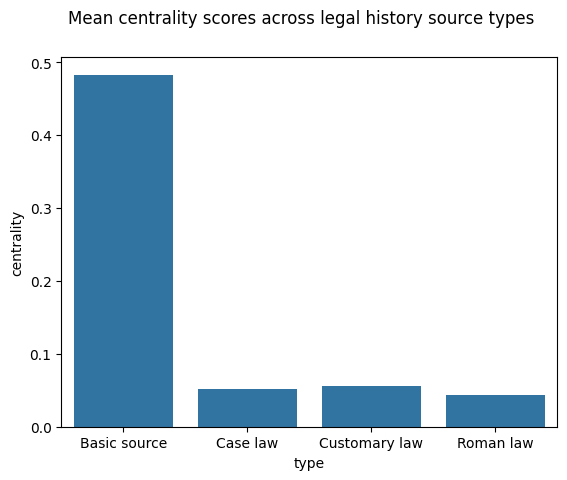

In [26]:
sns.barplot(x = grouped.index, y = grouped)
plt.suptitle("Mean centrality scores across legal history source types");

Even more, the dataframe format opens the door to the use of supervised and unsupervised learning algorithms, which falls outside of the scope of our discussion.